# Data Preparation

In [35]:
data_preproc = data.copy()

## Missing Value

In [34]:
# function to check missing values

import pandas as pd

def info_missing_value(data):
    """
    Calculate missing data statistics and return the missing data DataFrame.

    Parameters:
        data (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame containing the missing data statistics.
    """

    # Calculate the total count of missing values for each column
    total = data.isna().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / len(data) * 100).sort_values(ascending=False)
    length = len(data)

    missing_data = pd.DataFrame(total, columns=['Total'])
    missing_data['Percent']     = percent
    missing_data['Data_length'] = length
    missing_data = missing_data[missing_data['Total']>0]

    return missing_data

In [36]:
info_missing_value(data_preproc)

,Total,Percent,Data_length
rating,95,1.1875,8000
love,34,0.4250,8000
value_price,17,0.2125,8000
category,13,0.1625,8000
number_of_reviews,9,0.1125,8000
price,8,0.1000,8000


It can be observed that, apart from the `id`, `brand`, and `exclusive` columns, there are rows with missing values. The number of missing values is not significant, accounting for a maximum of approximately 1-2% of the data. To handle this, we will perform imputation using the median for numerical columns and the mode for categorical columns. Imputing with the median is more relevant due to the skewed distribution of the numerical data.

In [44]:
# missing value handling
numerical_null   = ['rating','love','value_price','number_of_reviews','price']

data_preproc[numerical_null]   = data_preproc[numerical_null].fillna(data_preproc[numerical_null].median())
data_preproc['category'].fillna(data_preproc['category'].mode(), inplace=True)

In [47]:
info_missing_value(data_preproc)

,Total,Percent,Data_length


## Duplicate Values

Kita cek apakah ada data yang duplikat dari dataset dengan menggunakan `duplicated` seperti di bawah ini:

In [ ]:
data.duplicated().sum()

0

Karena tidak ada data yang duplikat, kita dapat melanjutkan langsung ke tahap selanjutnya.

## Outliers

Dari grafik yang kita keluarkan ketika EDA, kita tahu bahwa hampir semua kolom numerik memiliki outlier. Sebelum kita mengeluarkan outlier, karena kita tahu bahwa bentuk distribusi kolom-kolom ini condong ke kiri, kita coba normalkan dengan `log transformation` kecuali untuk kolom `rating`:

In [ ]:
for num in nums:
  if num not in ['id', 'rating']:
    data[num] = np.log(data[num] + (data[data[num] > 0][num].min() / 2)) # kita harus pastikan data tidak 0 untuk dilogtransform

Kita coba sekali lagi munculkan violin plot untuk setiap kolom numerik:

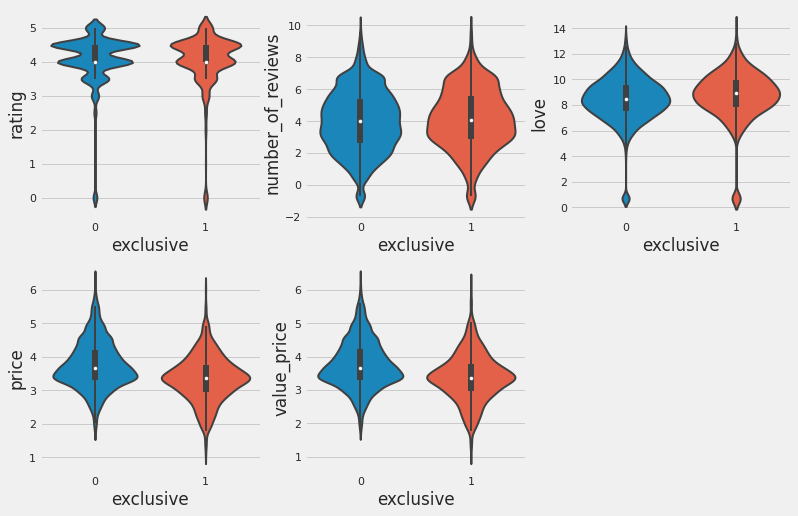

In [ ]:
plt.figure(figsize=(12, 8))
for i in range (0, len(nums)):
  plt.subplot(math.ceil(len(nums)/3), 3, i+1)
  sns.violinplot(data=data, y=nums[i], x='exclusive', linewidth=2, orient='v')

Perhatikan bahwa sekarang hampir semua kolom numerik terlihat memiliki distribusi berbentuk cukup normal. Untuk distribusi normal, kita bisa menggunakan *z-score* untuk membuang outlier seperti di bawah ini:

In [ ]:
from scipy import stats

print("Before removing outlier: ", len(data))

for num in nums:
  if num not in ['id', 'rating']:
    z_scores = np.abs(stats.zscore(data[num]))
    data = data[z_scores <= 3]

print("After removing outlier: ", len(data))

Before removing outlier:  7828
After removing outlier:  7642


Seperti yang terlihat di atas, kita menghapus sekitar ~200 baris yang berisi outlier berdasarkan *z-score*.


## Normalization/Standardization

Seperti yang telah dijelaskan di atas, semua kolom numerik kita sekarang memiliki bentuk distribusi yang lumayan normal. Oleh karena itu, kita akan melakukan standardisasi ke semua kolom kita seperti di bawah ini:

In [ ]:
from sklearn.preprocessing import StandardScaler

for num in nums:
  if num not in ['id', 'rating']:
    data[num] = StandardScaler().fit_transform(data[num].values.reshape(len(data), 1))

In [ ]:
data.describe()

,id,rating,number_of_reviews,love,price,value_price,exclusive
count,7.642000e+03,7642.000000,7.642000e+03,7.642000e+03,7.642000e+03,7.642000e+03,7642.000000
mean,1.921106e+06,4.090618,-3.611639e-16,1.777112e-15,1.720570e-15,2.174828e-16,0.258048
std,3.749298e+05,0.742894,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,0.437589
min,6.528000e+03,0.000000,-2.498086e+00,-3.773263e+00,-2.936247e+00,-2.922413e+00,0.000000
25%,1.785730e+06,4.000000,-6.982840e-01,-6.902560e-01,-5.727122e-01,-5.886384e-01,0.000000
50%,2.032664e+06,4.000000,-1.119889e-02,-2.746363e-02,-1.061831e-01,-1.279836e-01,0.000000
75%,2.187092e+06,4.500000,7.299845e-01,6.694274e-01,6.261422e-01,6.185186e-01,1.000000
max,2.293801e+06,5.000000,2.970600e+00,3.302054e+00,3.052605e+00,2.991030e+00,1.000000


Perhatikan bahwa kolom-kolom numerik kita sekarang memiliki simpangan baku = 1 dan rata-rata mendekati 0.

## Feature encoding

Dari EDA kita tahu bahwa kedua kolom kategorikal kita memiliki ratusan kemungkinan nilai. Meski begitu, dengan mempertimbangkan baris data yang hanya ada ~7500, kita akan tetap melakukan *one-hot encoding* dengan catatan apabila di masa depan ketika kita melakukan modeling prosesnya terlalu lambat, kita akan pertimbangkan menghapus kategorinya saja atu menggunakan label encoding.

In [ ]:
for cat in cats:
  data = pd.concat([data, pd.get_dummies(data[cat], prefix=cat)], axis=0)
  data.drop(columns=[cat], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30568 entries, 5 to 7999
Columns: 460 entries, id to category_no category
dtypes: float64(458), object(2)
memory usage: 107.5+ MB


Seperti yang terlihat, sekarang dataset memiliki ratusan kolom hasil *one-hot encoding* dari kolom kategorikalnya.

## Class imbalance
Kita bisa melakukan pengecekan class imbalance dengan menggunakan `value_counts`. Dapat dilihat bahwa perbandingan antara kelas positif dan negatif untuk kolom `exclusive` ada di sekitar 1:3, yang berarti tidak terjadi class imbalance.`

In [ ]:
data['exclusive'].value_counts()

0.0    5670
1.0    1972
Name: exclusive, dtype: int64

Kali ini, kita tidak akan melakukan sampling.

# Conclusion

*In conclusion*, kita sudah dengan sukses melakukan proses *pre-processing* berdasarkan hal yang sudah kita ketahui ketika EDA. Yang kita lakukan antara lain:
- Drop row *null*
- *Log transformation*
- Mengeluarkan *outlier* menggunakan *z-score*
- Standardisasi
- *Feature encoding*